# Predicting solubility

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

# for pipeline
from sklearn.pipeline import Pipeline

# for feature selection
from sklearn.feature_selection import SelectKBest, mutual_info_regression

# for pre-processing data
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split

# for performance evaluation
from sklearn.metrics import mean_squared_error, r2_score

# for building regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

## Loading and splitting data

In [3]:
# import dataset being used
df = pd.read_csv('aqsoldb.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9982 entries, 0 to 9981
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   9982 non-null   object 
 1   Name                 9982 non-null   object 
 2   InChI                9982 non-null   object 
 3   InChIKey             9982 non-null   object 
 4   SMILES               9982 non-null   object 
 5   Solubility           9982 non-null   float64
 6   SD                   9982 non-null   float64
 7   Ocurrences           9982 non-null   int64  
 8   Group                9982 non-null   object 
 9   MolWt                9982 non-null   float64
 10  MolLogP              9982 non-null   float64
 11  MolMR                9982 non-null   float64
 12  HeavyAtomCount       9982 non-null   float64
 13  NumHAcceptors        9982 non-null   float64
 14  NumHDonors           9982 non-null   float64
 15  NumHeteroatoms       9982 non-null   f

In [5]:
X = df.drop(df.columns[[0, 1, 2, 3, 4, 5, 6, 7, 8]], axis=1)

In [6]:
# creating y matrix from Solubility values
y = df['Solubility']

In [7]:
# split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

## Constant variables for each run

In [8]:
# list of regressors that are going to be compared
regressors = [LinearRegression(), RandomForestRegressor(), GradientBoostingRegressor(), SVR()]

In [9]:
# creating transformer which will carry out Yeo-Johnson transformation and also standardize the data
pt = PowerTransformer(method='yeo-johnson', standardize=True)

In [10]:
# select top features based on mutual_info_regression
selector = SelectKBest(mutual_info_regression)
selector.fit(X, y)
X.columns[selector.get_support()]

Index(['MolWt', 'MolLogP', 'MolMR', 'HeavyAtomCount', 'NumValenceElectrons',
       'NumAromaticRings', 'RingCount', 'LabuteASA', 'BalabanJ', 'BertzCT'],
      dtype='object')

In [11]:
selector.scores_

array([0.42025742, 0.58288916, 0.39824692, 0.33321592, 0.10337854,
       0.05897182, 0.09690515, 0.08554782, 0.33294945, 0.16545817,
       0.01653339, 0.02722199, 0.15673264, 0.11817894, 0.3661192 ,
       0.17399764, 0.26366803])

In [12]:
# looking at feature scores
scores = pd.DataFrame(data=[selector.feature_names_in_, selector.scores_])

In [13]:
scores

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,MolWt,MolLogP,MolMR,HeavyAtomCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
1,0.420257,0.582889,0.398247,0.333216,0.103379,0.058972,0.096905,0.085548,0.332949,0.165458,0.016533,0.027222,0.156733,0.118179,0.366119,0.173998,0.263668


In [14]:
scores_transposed = scores.transpose()
scores_transposed.rename(columns={0: 'Feature', 1: 'Score'}, inplace=True)
scores_transposed

,Feature,Score
0,MolWt,0.420257
1,MolLogP,0.582889
2,MolMR,0.398247
3,HeavyAtomCount,0.333216
4,NumHAcceptors,0.103379
5,NumHDonors,0.058972
6,NumHeteroatoms,0.096905
7,NumRotatableBonds,0.085548
8,NumValenceElectrons,0.332949
9,NumAromaticRings,0.165458


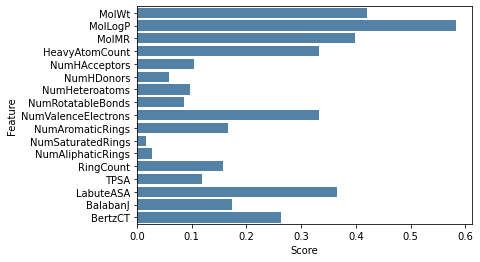

In [15]:
sns.barplot(data=scores_transposed, x='Score', y='Feature', color='steelblue')
# sns.set(rc = {'figure.figsize':(15,13)})
plt.savefig('solubility_features.jpg', bbox_inches='tight', dpi=300)
plt.show()

## Unprocessed data and untuned models (only thing done is splitting data into training and test sets)

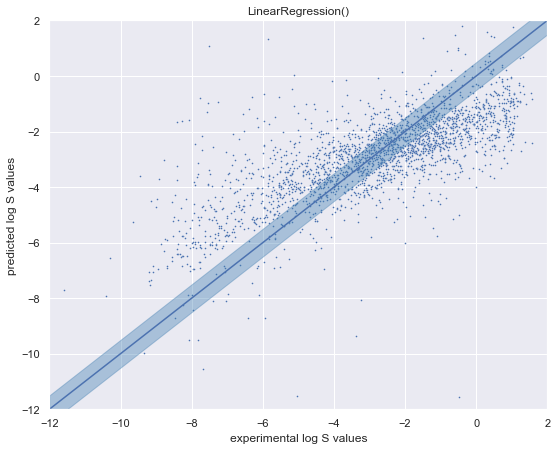

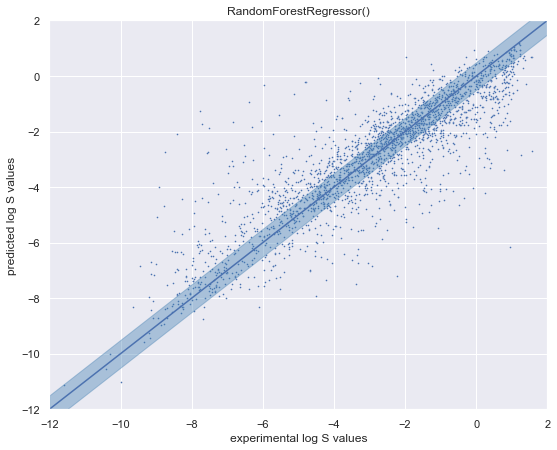

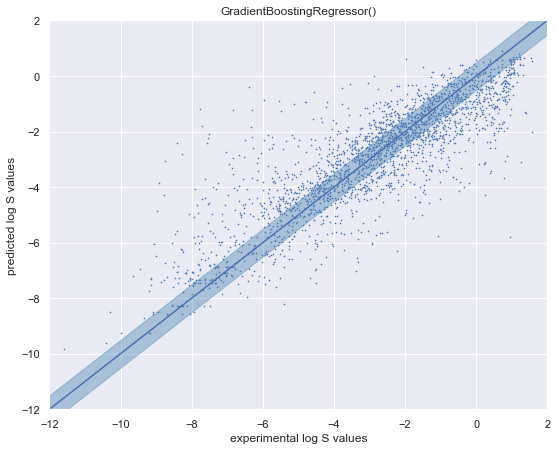

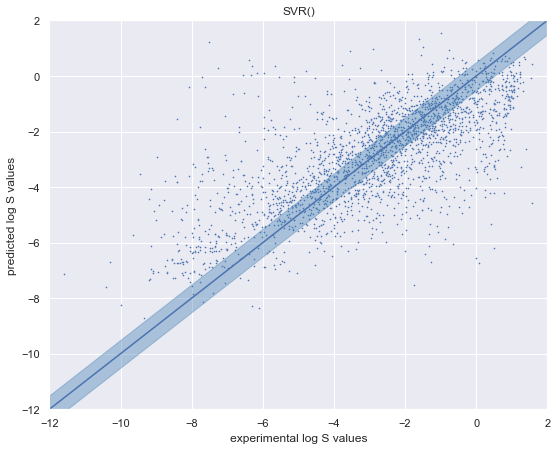

In [59]:
# empty lists to add info into 
models = ['Linear Regression', 'Random Forest Regressor', 'Gradient Boosting Regressor', 'Support Vector Regressor']
train_r2 = []
test_r2 = []
rmse = []

# iterate over every regressor
# enumerate adds a counter to the list which we can use later
for n, regressor in enumerate(regressors):
    
    # pipeline fitting and predicting using regressor
    pipeline = Pipeline(steps = [('regressor', regressor)])
    model = pipeline.fit(X_train, y_train)
    test_predictions = model.predict(X_test)
    train_predictions = model.predict(X_train)
    
    # append scores to lists
    train_r2.append(r2_score(y_train, train_predictions))
    test_r2.append(r2_score(y_test, test_predictions))
    rmse.append(mean_squared_error(y_test, test_predictions, squared=False))
    
    # setting plot settings
    plt.figure(figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)

    # create subplots
    ax = plt.subplot(2, 2, n+1)

    # plot scatter graphs of experimental values vs predicted values with x = y line
    ax = sns.scatterplot(x=y_test, y=test_predictions, s=3).set(title=f'{regressor}', xlabel='experimental log S values', ylabel='predicted log S values')

    # set axis limits to be the same
    plt.xlim(-12, 2)
    plt.ylim(-12, 2)

    # plot x=y line showing where accurate predictions lie
    sns.lineplot(x=[-12, 2], y=[-12, 2], alpha=1)

    # shaded areas show values that lie within the accepted +- 0.5 error zone
    exp_value = np.arange(-12, 3)
    upper_bound = exp_value + 0.5
    lower_bound = exp_value - 0.5
    plt.fill_between(exp_value, upper_bound, lower_bound, color='steelblue', alpha=0.4)
    
    plt.tight_layout()

    plt.savefig(f'{regressor}_solubility_test_set.jpg', bbox_inches='tight', dpi=300, transparent=True)
    plt.show()

# make dataframe out of lists
scores = pd.DataFrame({'Model': models, 'Train r2': train_r2, 'Test r2': test_r2, 'RMSE': rmse})

In [56]:
scores

,Model,Train r2,Test r2,RMSE
0,Linear Regression,0.519106,0.492611,1.701729
1,Random Forest Regressor,0.967148,0.766327,1.154846
2,Gradient Boosting Regressor,0.784518,0.726385,1.249654
3,Support Vector Regressor,0.535697,0.498251,1.692244


## Unprocessed data and untuned models (now also with feature selection)

['MolWt' 'MolLogP' 'MolMR' 'HeavyAtomCount' 'NumValenceElectrons'
 'LabuteASA']


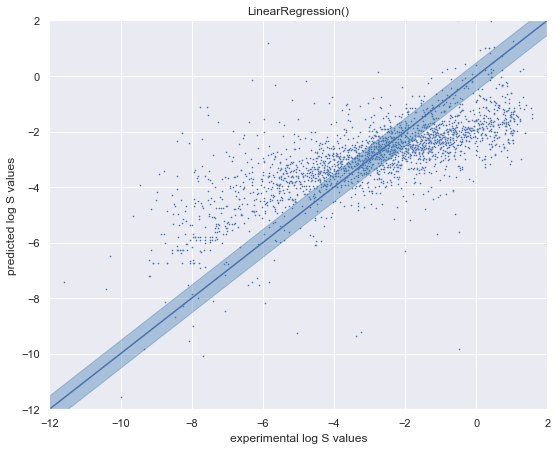

['MolWt' 'MolLogP' 'MolMR' 'HeavyAtomCount' 'NumValenceElectrons'
 'LabuteASA']


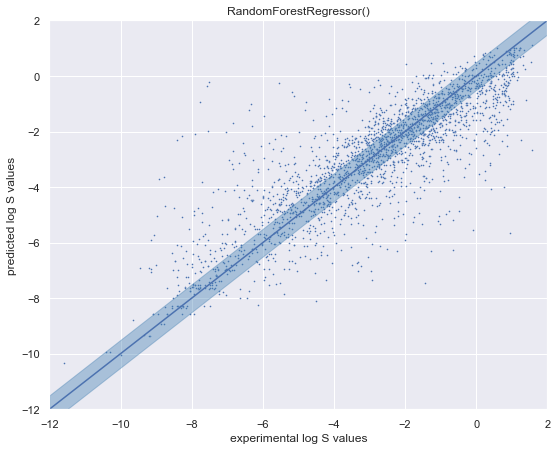

['MolWt' 'MolLogP' 'MolMR' 'HeavyAtomCount' 'NumValenceElectrons'
 'LabuteASA']


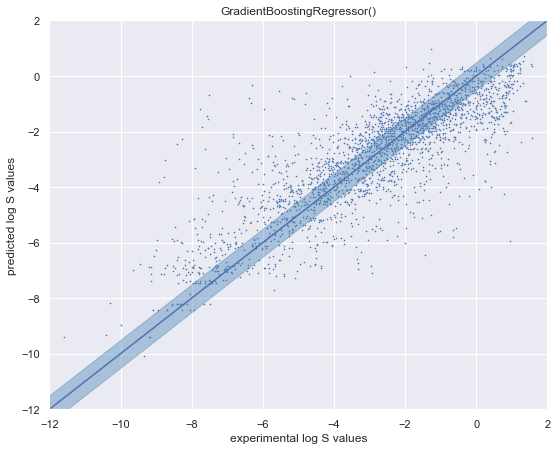

['MolWt' 'MolLogP' 'MolMR' 'HeavyAtomCount' 'NumValenceElectrons'
 'LabuteASA']


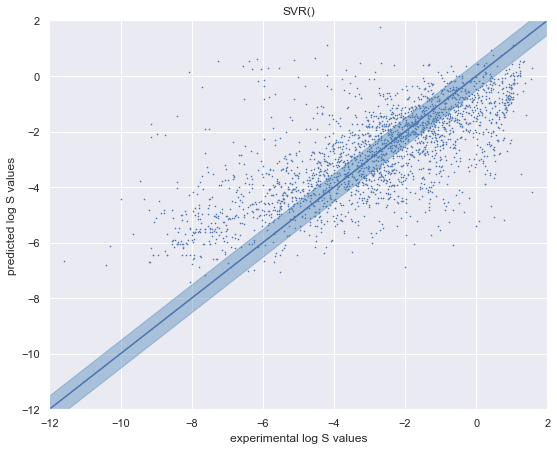

In [81]:
# empty lists to add info into 
models = ['Linear Regression', 'Random Forest Regressor', 'Gradient Boosting Regressor', 'Support Vector Regressor']
train_r2 = []
test_r2 = []
rmse = []

# iterate over every regressor
# enumerate adds a counter to the list which we can use later
for n, regressor in enumerate(regressors):
    
    # pipeline fitting and predicting using regressor
    pipeline = Pipeline(steps = [('selector', SelectKBest(mutual_info_regression, k=6)), ('regressor', regressor)])
    model = pipeline.fit(X_train, y_train)
    test_predictions = model.predict(X_test)
    train_predictions = model.predict(X_train)
    
    print (pipeline.named_steps['selector'].get_feature_names_out())                             
    
    # append scores to lists
    train_r2.append(r2_score(y_train, train_predictions))
    test_r2.append(r2_score(y_test, test_predictions))
    rmse.append(mean_squared_error(y_test, test_predictions, squared=False))
    
    # setting plot settings
    plt.figure(figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)

    # create subplots
    ax = plt.subplot(2, 2, n+1)

    # plot scatter graphs of experimental values vs predicted values with x = y line
    ax = sns.scatterplot(x=y_test, y=test_predictions, s=3).set(title=f'{regressor}', xlabel='experimental log S values', ylabel='predicted log S values')

    # set axis limits to be the same
    plt.xlim(-12, 2)
    plt.ylim(-12, 2)

    # plot x=y line showing where accurate predictions lie
    sns.lineplot(x=[-12, 2], y=[-12, 2], alpha=1)

    # shaded areas show values that lie within the accepted +- 0.5 error zone
    exp_value = np.arange(-12, 3)
    upper_bound = exp_value + 0.5
    lower_bound = exp_value - 0.5
    plt.fill_between(exp_value, upper_bound, lower_bound, color='steelblue', alpha=0.4)
    
    plt.tight_layout()

    plt.savefig(f'{regressor}_solubility_test_set_6_features.jpg', bbox_inches='tight', dpi=300, transparent=True)
    plt.show()

# make dataframe out of lists
scores = pd.DataFrame({'Model': models, 'Train r2': train_r2, 'Test r2': test_r2, 'RMSE': rmse})

In [80]:
scores

,Model,Train r2,Test r2,RMSE
0,Linear Regression,0.470916,0.453734,1.765719
1,Random Forest Regressor,0.958004,0.715049,1.275278
2,Gradient Boosting Regressor,0.746915,0.688965,1.332368
3,Support Vector Regressor,0.517416,0.499176,1.690682


## Pre-processed data and untuned models

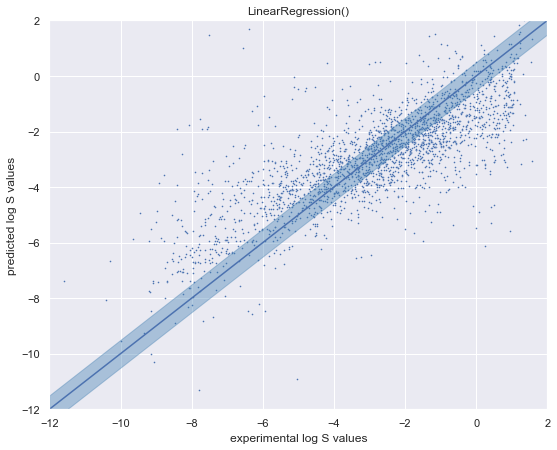

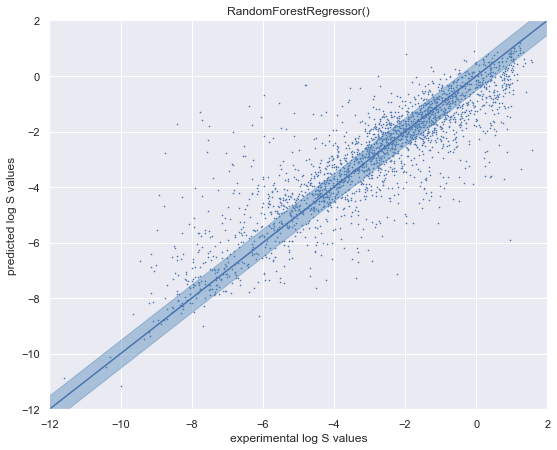

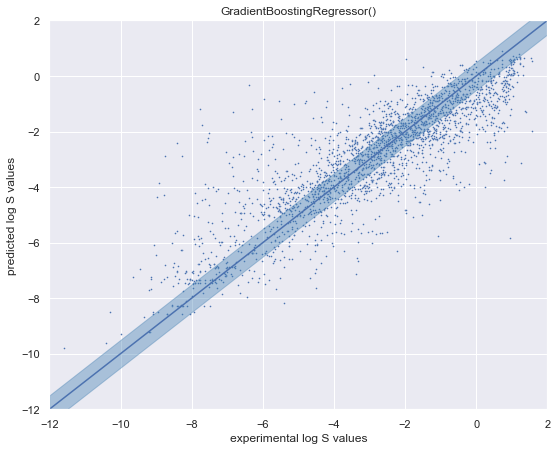

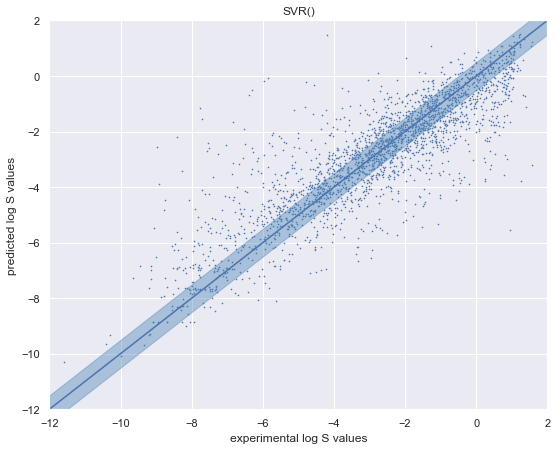

In [61]:
# empty lists to add info into 
models = ['Linear Regression', 'Random Forest Regressor', 'Gradient Boosting Regressor', 'Support Vector Regressor']
train_r2 = []
test_r2 = []
rmse = []

# iterate over every regressor
# enumerate adds a counter to the list which we can use later
for n, regressor in enumerate(regressors):
    
    # pipeline fitting and predicting using regressor
    pipeline = Pipeline(steps = [('transformer', pt), ('regressor', regressor)])
    model = pipeline.fit(X_train, y_train)
    test_predictions = model.predict(X_test)
    train_predictions = model.predict(X_train)
    
    # append scores to lists
    train_r2.append(r2_score(y_train, train_predictions))
    test_r2.append(r2_score(y_test, test_predictions))
    rmse.append(mean_squared_error(y_test, test_predictions, squared=False))
    
    # setting plot settings
    plt.figure(figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)

    # create subplots
    ax = plt.subplot(2, 2, n+1)

    # plot scatter graphs of experimental values vs predicted values with x = y line
    ax = sns.scatterplot(x=y_test, y=test_predictions, s=3).set(title=f'{regressor}', xlabel='experimental log S values', ylabel='predicted log S values')

    # set axis limits to be the same
    plt.xlim(-12, 2)
    plt.ylim(-12, 2)

    # plot x=y line showing where accurate predictions lie
    sns.lineplot(x=[-12, 2], y=[-12, 2], alpha=1)

    # shaded areas show values that lie within the accepted +- 0.5 error zone
    exp_value = np.arange(-12, 3)
    upper_bound = exp_value + 0.5
    lower_bound = exp_value - 0.5
    plt.fill_between(exp_value, upper_bound, lower_bound, color='steelblue', alpha=0.4)
    
    plt.tight_layout()

    plt.savefig(f'{regressor}_solubility_test_set_preprocessed.jpg', bbox_inches='tight', dpi=300, transparent=True)
    plt.show()

# make dataframe out of lists
scores = pd.DataFrame({'Model': models, 'Train r2': train_r2, 'Test r2': test_r2, 'RMSE': rmse})

In [62]:
scores

,Model,Train r2,Test r2,RMSE
0,Linear Regression,0.607152,0.576380,1.554919
1,Random Forest Regressor,0.967593,0.766389,1.154692
2,Gradient Boosting Regressor,0.784259,0.726244,1.249975
3,Support Vector Regressor,0.777291,0.741649,1.214297


## Preprocessed data and tuned hyperparameters

In [10]:
# empty lists to add info into 
models = ['Linear Regression', 'Random Forest Regressor', 'Gradient Boosting Regressor', 'Support Vector Regressor']
train_r2 = []
test_r2 = []
rmse = []

# iterate over every regressor
# enumerate adds a counter to the list which we can use later
for n, regressor in enumerate(regressors):
    
    # pipeline fitting and predicting using regressor
    pipeline = Pipeline(steps = [('transformer', pt), ('regressor', regressor)])
    
    # grid search cv
    cvFold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    search = GridSearchCV(pipeline, param_grid, n_iter=100, cv=cvFold, verbose=2, random_state=7, n_jobs=-1)
    search.fit(X_train, y_train)
    
    print(search.best_params_)
    
    best_model = search.best_estimator_
    test_predictions = best_model.predict(X_test)
    train_predictions = best_model.predict(X_train)
    
    # append scores to lists
    train_r2.append(r2_score(y_train, train_predictions))
    test_r2.append(r2_score(y_test, test_predictions))
    rmse.append(mean_squared_error(y_test, test_predictions, squared=False))
    
    # setting plot settings
    plt.figure(figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)

    # create subplots
    ax = plt.subplot(2, 2, n+1)

    # plot scatter graphs of experimental values vs predicted values with x = y line
    ax = sns.scatterplot(x=y_test, y=test_predictions, s=3).set(title=f'{regressor}', xlabel='experimental log S values', ylabel='predicted log S values')

    # set axis limits to be the same
    plt.xlim(-12, 2)
    plt.ylim(-12, 2)

    # plot x=y line showing where accurate predictions lie
    sns.lineplot(x=[-12, 2], y=[-12, 2], alpha=1)

    # shaded areas show values that lie within the accepted +- 0.5 error zone
    exp_value = np.arange(-12, 3)
    upper_bound = exp_value + 0.5
    lower_bound = exp_value - 0.5
    plt.fill_between(exp_value, upper_bound, lower_bound, color='steelblue', alpha=0.4)
    
    plt.tight_layout()

    plt.savefig(f'{regressor}_solubility_test_set_preprocessed_tuned.jpg', bbox_inches='tight', dpi=300, transparent=True)
    plt.show()

# make dataframe out of lists
scores = pd.DataFrame({'Model': models, 'Train r2': train_r2, 'Test r2': test_r2, 'RMSE': rmse})

NameError: name 'param_grid' is not defined

In [24]:
# parameter grid containing hyperparameters to tune
param_grid = {'regressor__max_depth': [int(x) for x in range(1, 200)],
              'regressor__max_features': ['auto', 'sqrt'],
              'regressor__min_samples_leaf': [2, 5, 10],
              'regressor__min_samples_split': [2, 4],
              'regressor__n_estimators': [int(x) for x in np.linspace(200, 2000, 10)]}

# pipeline fitting and predicting using regressor
pipeline = Pipeline(steps = [('transformer', pt), ('regressor', GradientBoostingRegressor())])
    
# grid search cv
cvFold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
search = RandomizedSearchCV(pipeline, param_grid, n_iter=100, cv=cvFold, verbose=2, random_state=7, n_jobs=-1)
search.fit(X_train, y_train)
    
print(search.best_params_)
    
best_model = search.best_estimator_
test_predictions = best_model.predict(X_test)
train_predictions = best_model.predict(X_train)
    
# append scores to lists
print(r2_score(y_train, train_predictions))
print(r2_score(y_test, test_predictions))
print(mean_squared_error(y_test, test_predictions, squared=False))
    
# plot scatter graphs of experimental values vs predicted values with x = y line
ax = sns.scatterplot(x=y_test, y=test_predictions, s=3).set(title=f'{regressor}', xlabel='experimental log S values', ylabel='predicted log S values')

# set axis limits to be the same
plt.xlim(-12, 2)
plt.ylim(-12, 2)

# plot x=y line showing where accurate predictions lie
sns.lineplot(x=[-12, 2], y=[-12, 2], alpha=1)

# shaded areas show values that lie within the accepted +- 0.5 error zone
exp_value = np.arange(-12, 3)
upper_bound = exp_value + 0.5
lower_bound = exp_value - 0.5
plt.fill_between(exp_value, upper_bound, lower_bound, color='steelblue', alpha=0.4)
    
plt.tight_layout()

plt.savefig('gbr_solubility_test_set_preprocessed_tuned.jpg', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

Fitting 30 folds for each of 100 candidates, totalling 3000 fits


KeyboardInterrupt: 

In [ ]:
# parameter grid containing hyperparameters to tune
param_grid = {'regressor__bootstrap': [True, False],
              'regressor__max_depth': [int(x) for x in range(1, 200)],
              'regressor__max_features': ['auto', 'sqrt'],
              'regressor__min_samples_leaf': [2, 5, 10],
              'regressor__min_samples_split': [2, 4],
              'regressor__n_estimators': [int(x) for x in np.linspace(200, 2000, 10)]}

# pipeline fitting and predicting using regressor
pipeline = Pipeline(steps = [('transformer', pt), ('regressor', RandomForestRegressor())])
    
# grid search cv
cvFold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
search = GridSearchCV(pipeline, param_grid, cv=cvFold, verbose=2, n_jobs=-1)
search.fit(X_train, y_train)
    
print(search.best_params_)
    
best_model = search.best_estimator_
test_predictions = best_model.predict(X_test)
train_predictions = best_model.predict(X_train)
    
# append scores to lists
print(r2_score(y_train, train_predictions))
print(r2_score(y_test, test_predictions))
print(mean_squared_error(y_test, test_predictions, squared=False))
    
# plot scatter graphs of experimental values vs predicted values with x = y line
ax = sns.scatterplot(x=y_test, y=test_predictions, s=3).set(title=f'{regressor}', xlabel='experimental log S values', ylabel='predicted log S values')

# set axis limits to be the same
plt.xlim(-12, 2)
plt.ylim(-12, 2)

# plot x=y line showing where accurate predictions lie
sns.lineplot(x=[-12, 2], y=[-12, 2], alpha=1)

# shaded areas show values that lie within the accepted +- 0.5 error zone
exp_value = np.arange(-12, 3)
upper_bound = exp_value + 0.5
lower_bound = exp_value - 0.5
plt.fill_between(exp_value, upper_bound, lower_bound, color='steelblue', alpha=0.4)
    
plt.tight_layout()

plt.savefig('rfr_solubility_test_set_preprocessed_tuned.jpg', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

In [ ]:
# pipeline fitting and predicting using regressor
pipeline = Pipeline(steps = [('transformer', pt), ('regressor', SVR())])

# parameter grid containing hyperparameters to tune
param_grid = {'regressor__kernel': ['linear', 'rbf', 'sigmoid', 'poly'], 
              'regressor__tol': [1e-3, 1e-4, 1e-5, 1e-6], 
              'regressor__C': [1, 1.5, 2, 2.5, 3]}

# grid search cv
cvFold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
search = GridSearchCV(pipeline, param_grid, cv=cvFold, verbose=2, n_jobs=-1)
search.fit(X_train, y_train)
    
print(search.best_params_)
    
best_model = search.best_estimator_
test_predictions = best_model.predict(X_test)
train_predictions = best_model.predict(X_train)
    
# append scores to lists
print(r2_score(y_train, train_predictions))
print(r2_score(y_test, test_predictions))
print(mean_squared_error(y_test, test_predictions, squared=False))
    
# plot scatter graphs of experimental values vs predicted values with x = y line
ax = sns.scatterplot(x=y_test, y=test_predictions, s=3).set(title=f'{regressor}', xlabel='experimental log S values', ylabel='predicted log S values')

# set axis limits to be the same
plt.xlim(-12, 2)
plt.ylim(-12, 2)

# plot x=y line showing where accurate predictions lie
sns.lineplot(x=[-12, 2], y=[-12, 2], alpha=1)

# shaded areas show values that lie within the accepted +- 0.5 error zone
exp_value = np.arange(-12, 3)
upper_bound = exp_value + 0.5
lower_bound = exp_value - 0.5
plt.fill_between(exp_value, upper_bound, lower_bound, color='steelblue', alpha=0.4)
    
plt.tight_layout()

plt.savefig('svr_solubility_test_set_preprocessed_tuned.jpg', bbox_inches='tight', dpi=300, transparent=True)
plt.show()